#### Part 3 - Jurrasic Fishbach
---
In this part you are going to apply segmentation on a video, and integrate with other elements.

<img src="https://lh3.googleusercontent.com/5zF16wl-tdE1FZCuVsrNxHWzfa6uXo4hYE_BGabKnGovw2W-bIT9gnZlAgU8nUoK=w412-h220-rw">

In [3]:
!git clone https://github.com/AlexYoro/CVHW.git
%cd CVHW/HW2/code/

fatal: destination path 'CVHW' already exists and is not an empty directory.
/content/CVHW/HW2/code


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import scipy
import os
import random
from skimage.io import imread
from PIL import Image
import glob

# pytorch
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

# define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


1. Film a short video of yourself (you can use your phone for that), but without too much camera movement. You on the other hand, can move however you want (we expect you to). Convert the video to frames and resize the images for a reasonable not too high resolution (lower than 720p ~ 1280x720 pixles). You can use the function in `./code/frame_video_convert.py` to help you. Display 2 frames in the report.

In [5]:
def video_to_image_seq(vid_path, output_path='./datasets/OTB/img/Custom/'):
    os.makedirs(output_path, exist_ok=True)
    vidcap = cv2.VideoCapture(vid_path)
    success, image = vidcap.read()
    count = 0
    print("converting video to frames...")
    while success:
        fname = str(count).zfill(4)
        cv2.imwrite(os.path.join(output_path, fname + ".jpg"), image)  # save frame as JPEG file
        success, image = vidcap.read()
        # print('Read a new frame: ', success)
        count += 1
    print("total frames: ", count)

Our Video:

In [6]:
video_path = '../data/my_data/my_video/first_try_Trim.mp4'
frames_path = '../data/my_data/output/output_frames/'
os.makedirs(frames_path, exist_ok=True)
video_to_image_seq(video_path,frames_path)

converting video to frames...
total frames:  158


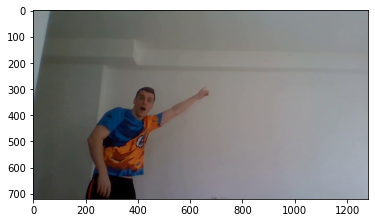

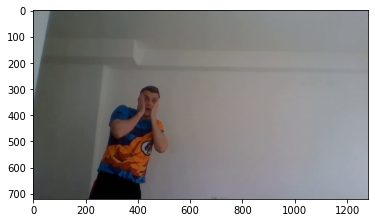

In [7]:
images = os.listdir(frames_path)
img1 = mpimg.imread(frames_path+random.choice(images))
img2 = mpimg.imread(frames_path+random.choice(images))
imgplot = plt.imshow(img1)
plt.show()
imgplot = plt.imshow(img2)
plt.show()

In [9]:
from google.colab import files

!zip -r output_frames.zip output_frames
files.download('output_frames.zip')

	zip warning: name not matched: output_frames

zip error: Nothing to do! (try: zip -r output_frames.zip . -i output_frames)


FileNotFoundError: ignored

2. Segment yourself out of the video (frame-by-frame) using one of the methods (classic or deep). Display 2 frames in the report.

In [6]:
def deeplab3_segmentation(images_path):
  """
  this function preform semantic segmentation on all images in a given path
  preform with black background and colorpallet
  input
    images_path: path for the dir with all images
  output:
  segmented: a list of segmented images with black background
   segmented_colors: a list of segmented images with colors
  """
  
  model = torch.hub.load('pytorch/vision:v0.5.0', 'deeplabv3_resnet101', pretrained=True)
  
  #inference mode
  model.eval();

  # define the pre-processing steps  image->tensor, normalization
  preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])
  
  frames = [dI for dI in sorted(os.listdir(images_path))] #put all the paths in array
  segmented=[] #will contain the output
  segmented_colors = [] #output colorpalete
  for frame in frames:

    input_image = Image.open(images_path+ frame)
    input_image_array = imread(images_path+ frame)

    # perform pre-processing
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch of size 1 as expected by the model

    # send to device
    model = model.to(device)
    input_batch = input_batch.to(device)
    # forward pass
    with torch.no_grad():
        output = model(input_batch)['out'][0]
    output_predictions = output.argmax(0)

    #create a mask to delete background
    masked_seg = np.array(output_predictions.byte().cpu().numpy(), dtype=bool)
    input_image_array[masked_seg == 0 ] = 0
    
    # create a color pallette, selecting a color for each class
    palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
    colors = (colors % 255).numpy().astype("uint8")
    # plot the semantic segmentation predictions of 21 classes in each color
    r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_image.size)
    r.putpalette(colors)
     
    segmented_colors.append(r)
    segmented.append(input_image_array)
  return segmented, segmented_colors

In [7]:
segmented_frames,colored_seg_frames = deeplab3_segmentation(frames_path)

Downloading: "https://github.com/pytorch/vision/zipball/v0.5.0" to /root/.cache/torch/hub/v0.5.0.zip
/usr/local/lib/python3.8/dist-packages/torch/hub.py:218: UserWarning: The ref v0.5.0 is ambiguous. Perhaps it is both a tag and a branch in the repo? Torchhub will now assume that it's a branch. You can disambiguate tags and branches by explicitly passing refs/heads/branch_name or refs/tags/tag_name as the ref. That might require using skip_validation=True.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_L

  0%|          | 0.00/233M [00:00<?, ?B/s]

In [8]:
my_video_segmented_path = "/content/CVHW/HW2/data/my_data/output/video_segmented/"
os.makedirs(my_video_segmented_path, exist_ok=True)

In [9]:
count = 0
for image in segmented_frames:
  fname = str(count).zfill(4)
  cv2.imwrite(os.path.join(my_video_segmented_path, fname + ".jpg"), image)  # save frame as JPEG file
  count += 1

print("total frames: ", count)

total frames:  158


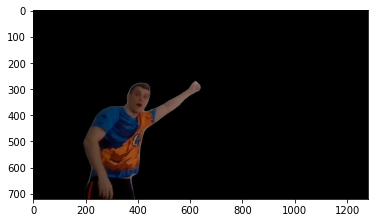

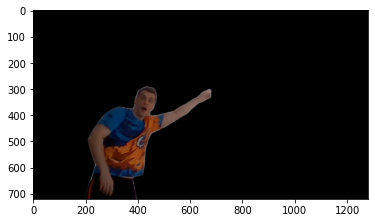

In [10]:
num_of_random = 2

for i in range(num_of_random):
  #segmented object
  random_pick = random.choice([ x for x in segmented_frames])
  # cv2.imwrite(os.path.join(my_video_segmented_path, str(i) + ".jpg"), random_pick)
  imgplot = plt.imshow(random_pick)
  plt.show()

3. Pick one of the objects in the supplied videos file (`./data/video_models`), convert it to images and segement it out using one of the methods from Part 1(classic or deep). Display 2 frames in the report. You can choose another object from: https://pixabay.com/videos/search/green%20screen/.
    * Explain how you performed the sementation for this specific type of video (i.e., green-screen videos). Did you  use a simple/classic method? Deep method? Combined both?

In [11]:
#UFO
ufo_video = '/content/CVHW/HW2/data/video_models/space_ship.mp4'
ufo_frames_path = '/content/CVHW/HW2/data/my_data/output/UFO_frames/'
ufo_segemented_path = '/content/CVHW/HW2/data/my_data/output/UFO_segmented/'
os.makedirs(ufo_frames_path, exist_ok=True)
os.makedirs(ufo_segemented_path, exist_ok=True)

In [12]:
video_to_image_seq(ufo_video,ufo_frames_path)

converting video to frames...
total frames:  250


In [13]:
def resize_figure(image,scale_percent=60):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)
  # resize image
  resized_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  return resized_image

In [14]:
from sklearn.cluster import KMeans
def kmeans_segment(images_path):

  frames = [dI for dI in sorted(os.listdir(images_path))]
  segmented=[]
  for frame in frames:
    pic = plt.imread(images_path+ frame)/255  # dividing by 255 to bring the pixel values between 0 and 1
    #resize to make it faster
    pic = resize_figure(pic,50)
    #reshape to a 3 dim stack
    pic_n = pic.reshape(pic.shape[0]*pic.shape[1], pic.shape[2])

    kmeans = KMeans(n_clusters=2, random_state=0).fit(pic_n)
    pic2show = kmeans.cluster_centers_[kmeans.labels_]

    cluster_pic = pic2show.reshape(pic.shape[0], pic.shape[1], pic.shape[2])
    pic[cluster_pic == cluster_pic[0]]=0

    #resize back
    pic = resize_figure(pic,200)

    segmented.append(pic)
  return segmented

In [2]:
ufo_segmented = kmeans_segment(ufo_frames_path)

NameError: ignored

In [ ]:
fixed_ufo=[]
for image in ufo_segmented:
  fixed_ufo.append(255*image)

In [1]:
fixed_ufo=[]
for image in ufo_segmented:
  fixed_ufo.append(255*image)

count = 0
for image in fixed_ufo:
  fname = str(count).zfill(4)
  cv2.imwrite(os.path.join(ufo_segemented_path, fname + ".jpg"), image)  # save frame as JPEG file
  count += 1

print("total frames: ", count)

NameError: ignored

In [ ]:
def plot_rand(num_of_frames, seg_frames):
  for i in range(num_of_frames):
    #segmented object
    random_pick = random.choice([ x for x in seg_frames])
    imgplot = plt.imshow(random_pick)
    plt.show()

In [ ]:
def display_im(images):
  """
  display images from the input list
  """
  fig, axes = plt.subplots(1,len(images),figsize=(15,10))
  for idx, image in enumerate(images):
    axes[idx].imshow(image)
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])
    axes[idx].axis('off')

In [ ]:
#print frames
ima=[]
for i in range(2):
  random_pick = random.choice([ x for x in ufo_segemented_path])
  ima.append(random_pick)
display_im(ima)

4. Put it all together - pick a background, put yourself and the segemented object on the background. Stich it frame-by-frame (don't make the video too long or it will take a lot of time, 10secs maximum). Display 2 frames of the result in your report. Convert the frames back to video. You can use the function in `frame_video_convert.py` to help you.
    * Tip: To make it look good, you can resize the images, create a mapping from pixel locations in the original image to pixels locations in the new image.
    * You should submit the final video in the `./output` folder (**MANDATORY**), and upload it to YouTube (**OPTIONAL**) as instructed above.
    * We expect some creative results, this can benefit you a lot when you want to demonstrate your Computer Vision abilities.